In [1]:
%env THEANO_FLAGS=device=gpu5,floatX=float32, lib.cnmem=0.5

from unet import build_UNet, build_Discriminator
from preproc import pics2array

import theano
import theano.tensor as T

import lasagne
from lasagne.layers import get_output, get_all_params

import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

env: THEANO_FLAGS=device=gpu5,floatX=float32, lib.cnmem=0.5


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 5: GeForce GTX 1080 (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [2]:
inputSat = T.tensor4("Input Satelite")
inputMap = T.tensor4("Input Map")

gener = build_UNet(inputSat, input_dim=(128, 128))
outputMap = get_output(gener["output"])

discrim = build_Discriminator(img_size=(128, 128))

legit_prob = get_output(discrim["output"], {discrim["input"] : inputMap})
fake_prob = get_output(discrim["output"], {discrim["input"] : outputMap})

In [3]:
l1_loss = T.abs_(inputMap - outputMap).mean()
gen_loss = -(T.log(fake_prob)).mean()

lambd = 100

combo_loss = l1_loss*lambd + gen_loss

discr_loss = -(T.log(legit_prob) + T.log(1 - fake_prob)).mean()

In [4]:
D_params = get_all_params(discrim["output"], trainable=True)
D_updates = lasagne.updates.adam(discr_loss, D_params, 2e-4, beta1=0.5)
D_train = theano.function([inputMap, inputSat], discr_loss, updates=D_updates)

In [5]:
G_params = get_all_params(gener["output"], trainable=True)
G_updates = lasagne.updates.adam(combo_loss, G_params, 2e-4, beta1=0.5) #4e-4
G_train = theano.function([inputMap, inputSat], combo_loss, updates=G_updates)

In [6]:
reconstruct = theano.function([inputSat], outputMap, allow_input_downcast=True)

In [7]:
sats = sorted(filter(lambda x: x.split(".")[1]=="sat", os.listdir("data/")))
maps = sorted(filter(lambda x: x.split(".")[1]=="map", os.listdir("data/")))

In [8]:
sats = pics2array("data/", sats)
maps = pics2array("data/", maps)

In [9]:
sats = np.array(sats, dtype="float32")/255
maps = np.array(maps, dtype="float32")/255

In [ ]:
n_epochs = 50
batch_size = 5

for epoch in range(n_epochs):
    print epoch + 1
    for i in range(0, len(maps) - batch_size, batch_size):
        D_train(maps[i : i + batch_size], sats[i : i + batch_size])
        
        for k in range(4):
            G_train(maps[i : i + batch_size], sats[i : i + batch_size])

1
2
3
4
5
6
7
8
9
10
13


In [22]:
pos = 2000

pic = reconstruct(sats[pos : pos + 1])

plt.imshow(pic[0].transpose(1, 2, 0))
plt.show()

plt.imshow(sats[pos].transpose(1, 2, 0))
plt.show()

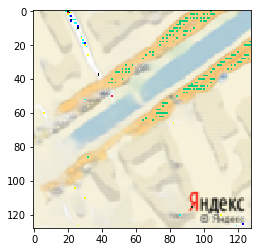

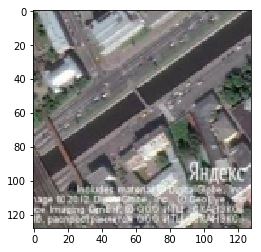